# Fine tune a Base Model (5 steps)


In [1]:
# Install necessary libraries
# LoRA fine-tuning requires PEFT, Transformers, Datasets, and Accelerate
# bitsandbytes is for 4-bit quantization (QLoRA)
!pip install -q -U transformers datasets peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 18.7 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

In [ ]:

# A small 3B model for this example.
# We load it in 4-bit to save memory (QLoRA)
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"

In [ ]:
from huggingface_hub import login
# Hugging Face login
hf_token = "hf_iGWjRtjobCydZbVOTLOXXXXXXXX"  # Replace with your HF token
login(hf_token)


In [ ]:
# w and b settins
import os
# Configure WANDB
os.environ["WANDB_API_KEY"] = "6f8cc13db6ea6485b46be0edda82256d4XXXXX"
import wandb
wandb.init(project="my-finetuning", name=f"qlora-{MODEL_NAME.split('/')[-1]}")

eval/loss,█▄▂▂▁▁▁
eval/runtime,▄▅█▁▆▄▃
eval/samples_per_second,▅▄▁█▃▅▆
eval/steps_per_second,▅▄▁█▃▅▆
train/epoch,▁▂▂▃▄▄▅▅▆▇▇▇█▁▂▂▂▃▃▄▅▅▅▆▆▇▇▇█
train/global_step,▁▂▂▃▄▄▅▅▆▇▇▇█▁▂▂▂▃▃▄▅▅▅▆▆▇▇▇█
train/grad_norm,█▂▂▂▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▂
train/learning_rate,█▇▆▆▅▄▃▃▂▁█▇▆▆▅▄▃▃▂▁
train/loss,█▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
eval/loss,0.67353
eval/runtime,10.7481


In [ ]:

# Import the required libraries
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os


In [ ]:
# 1. Load the Model and Tokenizer

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("Loading model and tokenizer...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Qwen tokenizer needs a pad token set explicitly
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Important for batched inference

Loading model and tokenizer...


In [ ]:
# # 2. Load and Preprocess the Dataset
# # We'll use a small subset of the databricks-dolly-15k dataset.
# print("Loading dataset...")
# dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

# # Select a small number of samples for a quick demonstration
# subset_size = 500
# dataset = dataset.select(range(subset_size))

# # Function to format the data into an instruction-following prompt
# def format_prompt(sample):
#     if sample["instruction"] and sample["context"]:
#         # Format for instruction with context
#         prompt = f"### Instruction:\n{sample['instruction']}\n\n### Context:\n{sample['context']}\n\n### Response:\n{sample['response']}{tokenizer.eos_token}"
#     else:
#         # Format for instruction without context
#         prompt = f"### Instruction:\n{sample['instruction']}\n\n### Response:\n{sample['response']}{tokenizer.eos_token}"
#     return {"text": prompt}

# # Apply the formatting and tokenize the dataset
# dataset = dataset.map(format_prompt, remove_columns=list(dataset.features.keys()))

# def tokenize_function(examples):
#     # This is the corrected part
#     tokenized_output = tokenizer(examples["text"], truncation=True, padding=True, max_length=512)
#     # For causal language modeling, the labels are the same as the input_ids
#     tokenized_output["labels"] = tokenized_output["input_ids"].copy()
#     return tokenized_output

# tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
# 2. Load and Preprocess the Dataset
# We'll use a small subset of the databricks-dolly-15k dataset.
print("Loading dataset...")
dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

# Select a small number of samples for a quick demonstration
subset_size = 500
dataset = dataset.select(range(subset_size))

# --- NEW: Split the dataset into 85% training and 15% evaluation ---
dataset_split = dataset.train_test_split(test_size=0.15, seed=42)
train_dataset = dataset_split['train']
eval_dataset = dataset_split['test']

# Function to format the data into an instruction-following prompt
def format_prompt(sample):
    if sample["instruction"] and sample["context"]:
        prompt = f"### Instruction:\n{sample['instruction']}\n\n### Context:\n{sample['context']}\n\n### Response:\n{sample['response']}{tokenizer.eos_token}"
    else:
        prompt = f"### Instruction:\n{sample['instruction']}\n\n### Response:\n{sample['response']}{tokenizer.eos_token}"
    return {"text": prompt}

# Apply formatting and tokenize to BOTH splits
train_dataset = train_dataset.map(format_prompt, remove_columns=list(dataset.features.keys()))
eval_dataset = eval_dataset.map(format_prompt, remove_columns=list(dataset.features.keys()))

def tokenize_function(examples):
    tokenized_output = tokenizer(examples["text"], truncation=True, padding=True, max_length=512)
    tokenized_output["labels"] = tokenized_output["input_ids"].copy()
    return tokenized_output

# Tokenize both datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Loading dataset...


Map:   0%|          | 0/75 [00:00<?, ? examples/s]

In [ ]:
# 3. Configure and Prepare LoRA
# Prepare the model for k-bit training and apply LoRA
print("Preparing model for LoRA fine-tuning...")
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# LoRA configuration
lora_config = LoraConfig(
    r=16, # Rank of the update matrices
    lora_alpha=32, # A scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Layers to apply LoRA to
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
print("LoRA-enabled model trainable parameters:")
model.print_trainable_parameters()


Preparing model for LoRA fine-tuning...
LoRA-enabled model trainable parameters:
trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


In [ ]:
# 4. Train the Model
output_dir = "qwen1.5-1.5b-lora-dolly-finetuned"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    learning_rate=2e-6,
    fp16=True,
    logging_steps=10,
    # --- NEW: Enable evaluation during training ---
    eval_strategy="steps",
    eval_steps=20,  # Evaluate every 100 training steps
    load_best_model_at_end=True, # Load the best model based on evaluation loss
    # --- FIX: Align save_strategy with eval_strategy ---
    save_strategy="steps", # Save checkpoint every `save_steps`
    save_steps=20, # Save every 100 steps to match eval_steps

    max_steps=200,  # Direct control - ignores num_train_epochs
)

# Initialize the Trainer
print("Starting training...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    # --- NEW: Provide the evaluation dataset ---
    eval_dataset=tokenized_eval_dataset,
)

# Start training
trainer.train()

# Save the fine-tuned model
print(f"Training complete. Saving model to {output_dir}")
trainer.save_model(output_dir)

Starting training...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
20,6.633500,6.506318
40,6.238100,6.344378
60,5.925500,6.195878
80,6.315000,6.061641
100,6.224800,5.937949
120,5.823200,5.834892
140,5.674300,5.750713
160,5.601800,5.688202
180,5.532700,5.652578
200,5.483600,5.640906


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/

Training complete. Saving model to qwen1.5-1.5b-lora-dolly-finetuned


# Data Visualization

### Training and Validation Loss Curves

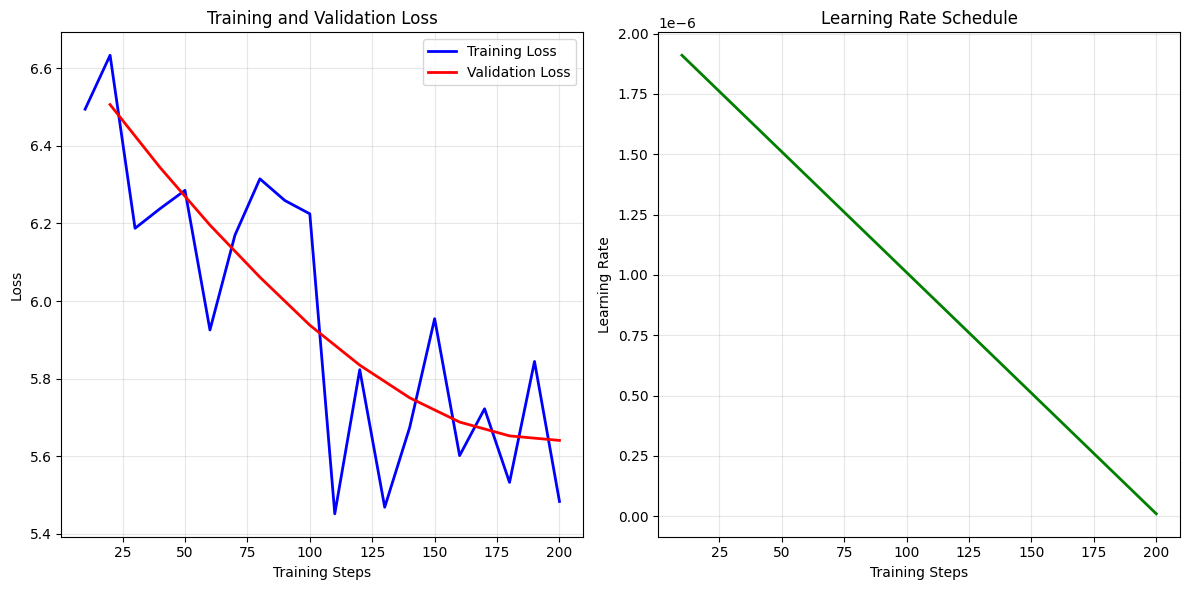

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

# Method 1: Extract from trainer.state.log_history (if training just completed)
def plot_loss_curves_from_trainer(trainer):
    """Plot loss curves directly from trainer object"""
    log_history = trainer.state.log_history

    # Extract training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    # Create DataFrames
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    # Plot the curves
    plt.figure(figsize=(12, 6))

    # Training loss
    plt.subplot(1, 2, 1)
    if not train_df.empty:
        plt.plot(train_df['step'], train_df['loss'], 'b-', label='Training Loss', linewidth=2)
    if not eval_df.empty:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning rate (if available)
    plt.subplot(1, 2, 2)
    if 'learning_rate' in train_df.columns:
        plt.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return train_df, eval_df

# Method 2: Load from saved trainer_state.json file
def plot_loss_curves_from_file(output_dir):
    """Plot loss curves from saved trainer state file"""
    trainer_state_path = os.path.join(output_dir, "trainer_state.json")

    if not os.path.exists(trainer_state_path):
        print(f"trainer_state.json not found in {output_dir}")
        return None, None

    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)

    log_history = trainer_state['log_history']

    # Extract training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    # Create DataFrames
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    # Plot the curves
    plt.figure(figsize=(15, 5))

    # Combined loss plot
    plt.subplot(1, 3, 1)
    if not train_df.empty:
        plt.plot(train_df['step'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if not eval_df.empty:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Training loss only (zoomed)
    plt.subplot(1, 3, 2)
    if not train_df.empty:
        plt.plot(train_df['step'], train_df['loss'], 'b-', linewidth=2, marker='o', markersize=4)
        plt.xlabel('Training Steps')
        plt.ylabel('Training Loss')
        plt.title('Training Loss (Detailed)')
        plt.grid(True, alpha=0.3)

    # Learning rate
    plt.subplot(1, 3, 3)
    if not train_df.empty and 'learning_rate' in train_df.columns:
        plt.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Learning Rate\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if not train_df.empty:
        print("\nTraining Loss Summary:")
        print(f"Initial Loss: {train_df['loss'].iloc[0]:.4f}")
        print(f"Final Loss: {train_df['loss'].iloc[-1]:.4f}")
        print(f"Loss Reduction: {train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}")

    if not eval_df.empty:
        print("\nValidation Loss Summary:")
        print(f"Best Validation Loss: {eval_df['eval_loss'].min():.4f}")
        print(f"Final Validation Loss: {eval_df['eval_loss'].iloc[-1]:.4f}")

    return train_df, eval_df

# Method 3: Advanced plotting with smoothing
def plot_advanced_loss_curves(output_dir, smooth_factor=0.1):
    """Plot advanced loss curves with smoothing and additional metrics"""
    from scipy.ndimage import uniform_filter1d

    trainer_state_path = os.path.join(output_dir, "trainer_state.json")

    if not os.path.exists(trainer_state_path):
        print(f"trainer_state.json not found in {output_dir}")
        return None, None

    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)

    log_history = trainer_state['log_history']

    # Extract training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    plt.figure(figsize=(16, 10))

    # Main loss plot with smoothing
    plt.subplot(2, 2, 1)
    if not train_df.empty:
        train_loss = train_df['loss'].values
        train_steps = train_df['step'].values

        # Apply smoothing
        if len(train_loss) > 5:
            smooth_train_loss = uniform_filter1d(train_loss, size=max(1, int(len(train_loss) * smooth_factor)))
            plt.plot(train_steps, smooth_train_loss, 'b-', label='Training Loss (Smoothed)', linewidth=2, alpha=0.8)
            plt.plot(train_steps, train_loss, 'b-', label='Training Loss (Raw)', linewidth=1, alpha=0.3)
        else:
            plt.plot(train_steps, train_loss, 'b-', label='Training Loss', linewidth=2, marker='o')

    if not eval_df.empty:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss',
                linewidth=2, marker='s', markersize=6, alpha=0.8)

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss difference plot
    plt.subplot(2, 2, 2)
    if not train_df.empty and not eval_df.empty:
        # Interpolate training loss to match eval steps
        import numpy as np
        eval_steps = eval_df['step'].values
        train_loss_interp = np.interp(eval_steps, train_df['step'], train_df['loss'])
        loss_diff = eval_df['eval_loss'].values - train_loss_interp

        plt.plot(eval_steps, loss_diff, 'purple', linewidth=2, marker='o')
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.xlabel('Training Steps')
        plt.ylabel('Validation - Training Loss')
        plt.title('Overfitting Indicator')
        plt.grid(True, alpha=0.3)

        # Add text annotation
        if np.mean(loss_diff) > 0:
            plt.text(0.05, 0.95, 'Potential Overfitting\n(Val > Train)',
                    transform=plt.gca().transAxes, va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Learning rate subplot
    plt.subplot(2, 2, 3)
    if not train_df.empty and 'learning_rate' in train_df.columns:
        plt.semilogy(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate (log scale)')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)

    # Training speed subplot
    plt.subplot(2, 2, 4)
    if not train_df.empty and 'train_samples_per_second' in train_df.columns:
        plt.plot(train_df['step'], train_df['train_samples_per_second'], 'orange', linewidth=2)
        plt.xlabel('Training Steps')
        plt.ylabel('Samples/Second')
        plt.title('Training Speed')
        plt.grid(True, alpha=0.3)
    elif not train_df.empty:
        # Show loss rate of change
        if len(train_df) > 1:
            loss_diff = np.diff(train_df['loss'])
            step_diff = np.diff(train_df['step'])
            loss_rate = -loss_diff / step_diff  # Negative because we want positive when loss decreases

            plt.plot(train_df['step'][1:], loss_rate, 'orange', linewidth=2)
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            plt.xlabel('Training Steps')
            plt.ylabel('Loss Decrease Rate')
            plt.title('Learning Progress Rate')
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return train_df, eval_df

# Usage examples:

# If you just finished training and have the trainer object:
train_df, eval_df = plot_loss_curves_from_trainer(trainer)





In [ ]:

# If you want to load from saved files:
output_dir = "qwen1.5-1.5b-lora-dolly-finetuned"  # Your model output directory

# Basic plotting
print("Creating basic loss curves...")
train_df, eval_df = plot_loss_curves_from_file(output_dir)

# Advanced plotting with smoothing
print("\nCreating advanced loss curves...")
train_df_adv, eval_df_adv = plot_advanced_loss_curves(output_dir)

# Optional: Save the plots
def save_loss_plots(output_dir):
    """Save loss plots as PNG files"""
    import matplotlib.pyplot as plt

    # Recreate the plots
    train_df, eval_df = plot_loss_curves_from_file(output_dir)

    # Save the current figure
    plt.savefig(os.path.join(output_dir, 'loss_curves.png'), dpi=300, bbox_inches='tight')
    print(f"Loss curves saved to {os.path.join(output_dir, 'loss_curves.png')}")

# Uncomment to save plots:
# save_loss_plots(output_dir)

In [ ]:

# 5. Save the Fine-Tuned Model Locally
# The trainer automatically saves the LoRA adapter weights
print(f"Training complete. Saving model to {output_dir}")
trainer.save_model(output_dir)

print("Fine-tuning successful! The LoRA weights are saved in the specified directory.")

Training complete. Saving model to qwen1.5-1.5b-lora-dolly-finetuned
Fine-tuning successful! The LoRA weights are saved in the specified directory.


In [ ]:
# 6. Save the Fine-Tuned Model Locally ->>> to Huggaing Face

from huggingface_hub import notebook_login

notebook_login()



from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# The directory where you saved your LoRA adapters
local_adapter_dir = "qwen1.5-1.5b-lora-dolly-finetuned"
# The name of your new repository on the Hugging Face Hub
hub_repo_id = "YOUR_USERNAME/your-qwen-lora-model"
hub_repo_id = "Basharat78/qwen1.5-1.5b-lora-dolly-finetuned"
# Replace YOUR_USERNAME with your actual Hugging Face username

# Push the adapter and tokenizer files to the Hub
# The push_to_hub() method handles the creation of the repo and file upload automatically
try:
    finetuned_model.push_to_hub(hub_repo_id)
    tokenizer.push_to_hub(hub_repo_id)
    print(f"Model and tokenizer successfully uploaded to {hub_repo_id}")
except Exception as e:
    print(f"An error occurred during upload: {e}")

An error occurred during upload: name 'finetuned_model' is not defined


# Evaluate the locally saved and Finetuned Model (3 steps)

In [ ]:
# 1. Load the base model

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# Load the base model in 4-bit, just like during training
model_id = "Qwen/Qwen2-1.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # Change padding side for inference


In [ ]:
# 2. Load local finetuned adapter

# Path to your saved LoRA adapter weights
adapter_path = "qwen1.5-1.5b-lora-dolly-finetuned"

print(f"Loading LoRA adapter from {adapter_path}...")
model = PeftModel.from_pretrained(base_model, adapter_path)

# You can optionally merge the adapter weights into the base model
# This is useful for saving the final model for deployment and can improve inference speed.
# model = model.merge_and_unload()

Loading LoRA adapter from qwen1.5-1.5b-lora-dolly-finetuned...


In [ ]:
# 3. Test the prompt

# Test the model with a sample prompt
prompt = "### Instruction:\nWhat are the benefits of a plant-based diet?\n\n### Response:"

# Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

print("Generating response...")
# Generate a response from the model
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

# Decode and print the generated output
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the full generated text
print("\n--- Generated Output ---")
print(generated_text)

Generating response...

--- Generated Output ---
### Instruction:
What are the benefits of a plant-based diet?

### Response: 
The benefits of a plant-based diet include reduced risk for many types of diseases, including cancer and heart disease. It also can improve digestion, reduce the need for antibiotics, and help you stay within your recommended daily calorie intake. Additionally, it is considered more sustainable than a meat-based diet as it requires less water to produce and produces fewer greenhouse gases.


# Compare the Base and (Locally) Finetuned models side-by-side

In [ ]:
# ###
# Side-by-Side Comparison Code
# This script will:

# Load the original base model (the same one you started with).

# Load your fine-tuned model (which has the LoRA adapter).

# Use the exact same prompt for both models.

# Print the output from each model clearly labeled, so you can see the difference.

###


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# Define the model ID and adapter path
model_id = "Qwen/Qwen2-1.5B-Instruct"
adapter_path = "qwen1.5-1.5b-lora-dolly-finetuned"

# Configure 4-bit quantization for consistent loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 1. Load the Base Model
# This is the original model without any fine-tuning.
print("Loading the original base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# 2. Load the Fine-Tuned Model (Base Model + LoRA)
# This model has your fine-tuned weights applied.
print(f"Loading the fine-tuned model with LoRA adapter from {adapter_path}...")
finetuned_model = PeftModel.from_pretrained(base_model, adapter_path)

# 3. Define the Prompt
# Use the exact same prompt for both models to ensure a fair comparison.
prompt = "### Instruction:\nWhat are the benefits of a plant-based diet?\n\n### Response:"

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# 4. Generate Output from Both Models
print("\n--- Generating output from the ORIGINAL base model ---")
with torch.no_grad():
    base_outputs = base_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )
base_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
print(base_text)

print("\n--- Generating output from the FINE-TUNED model ---")
with torch.no_grad():
    finetuned_outputs = finetuned_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )
finetuned_text = tokenizer.decode(finetuned_outputs[0], skip_special_tokens=True)
print(finetuned_text)

Loading the original base model...
Loading the fine-tuned model with LoRA adapter from qwen1.5-1.5b-lora-dolly-finetuned...

--- Generating output from the ORIGINAL base model ---
### Instruction:
What are the benefits of a plant-based diet?

### Response: Plant-based diets have several health advantages over their meat-based counterparts. These include:

- Lower risk of cardiovascular disease
- Lower blood pressure
- Lower cholesterol levels
- Better bone density
- Less cancer risk
- Fewer gastrointestinal disorders

Additionally, studies show that plant-based diets can reduce the amount of calories needed to maintain weight and improve energy levels.
Sources:
http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120739/
https://www.nutrition.org/articles/how-dietary-fat-affects-blood-pressure-and-heart-health/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5684190/

--- Generating output from the FINE-TUNED model ---
### Instruction:
What are the benefits of a plant-based diet?

### Response: T

# Load model from HF and test it
###  Loading the Model from Anywhere

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# Define the full repository ID for your uploaded model
hub_repo_id = "Basharat78/qwen1.5-1.5b-lora-dolly-finetuned"

# Define the original base model's ID
base_model_id = "Qwen/Qwen2-1.5B-Instruct"

# 1. Load the base model with quantization
print("Loading the original base model...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# 2. Load the fine-tuned LoRA adapter from the Hugging Face Hub
# The from_pretrained() method from PEFT will automatically download your adapter files
print(f"Loading LoRA adapter from {hub_repo_id}...")
finetuned_model = PeftModel.from_pretrained(base_model, hub_repo_id)

# 3. Use the model for inference with the same prompt
prompt = "### Instruction:\nWhat are the benefits of a plant-based diet?\n\n### Response:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

print("Generating response from the loaded Hub model...")
with torch.no_grad():
    outputs = finetuned_model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n--- Generated Output from Hugging Face Hub Model ---")
print(generated_text)

Loading the original base model...
Loading LoRA adapter from Basharat78/qwen1.5-1.5b-lora-dolly-finetuned...


adapter_config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Generating response from the loaded Hub model...

--- Generated Output from Hugging Face Hub Model ---
### Instruction:
What are the benefits of a plant-based diet?

### Response: Plant based diets can help prevent heart disease, stroke, type 2 diabetes and obesity. They can also improve kidney function in individuals with chronic kidney disease, which is why they are often recommended for people who have kidney disease. In addition, they provide a wide range of vitamins and minerals that are often lacking in animal based diets. This includes vitamin B12, which is only found in fortified foods in small amounts. There are many other health benefits of eating more fruits and vegetables including improved gut health, reduced risk of certain cancers, and decreased risk of osteoporosis.
